In [ ]:
import pulp
import numpy as np
import matplotlib.pyplot as plt
import time

# SCybsec_L(Pmax)

## Original

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def minimize_Pmax(c, d, p, q, V, r, budget, H):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Minimize_Pmax", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node
    Pmax = pulp.LpVariable("Pmax", lowBound=0)


    # Define constraints
    # yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    # yes
    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))
                # else:
                #     prob += (pulp.lpSum(r[i][j][l] * v[i, j, l_prime] for l_prime in range(num_levels))== 0)
    #yes
    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))

    # Budget constraint
    # yes
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
    
    # New constraint for Pmax
    for i in range(num_nodes):
        prob += p[i] * W[i] + pulp.lpSum(q * p[h] * W[h] for h in H[i]) <= Pmax

    # Define objective function
    prob += Pmax

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # Solve using CBC with 4 threads
    # solver = pulp.PULP_CBC_CMD(threads=4, msg=True)
    # prob.solve(solver)

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
           
    # print("W")
    # for i in range(num_nodes):
    #     print(f"W[{i}] = {W[i].varValue}")

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Cybersecurity investment per node
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].varValue for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    
    # breach probability by node
    breach_prob_per_node = [p[i] * W[i].varValue + sum(q * p[h] * W[h].varValue for h in H[i]) for i in range(num_nodes)]

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    print("Objective function:", minimized_value/1000)
    print("Pmax: ", Pmax.varValue)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment,  minimized_value, Pmax.varValue, end_time - start_time, cybersecurity_investment_per_node, breach_prob_per_node


def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
q = 0.1
children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9]]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]
# Calculate r
r = calculate_r(V, e, c)
budgets = range(0, 501, 100)
# budgets = [1000, 5000, 10000, 15000, 25000]

cybersecurity_investments = []
minimized_values = []
Pmax_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, minimized_value, Pmax, cpu_time, C_per_node, breach_per_node = minimize_Pmax(c, d, p, q, V, r, budget*1000, h_parents)
    cybersecurity_investments.append(investment)
    minimized_values.append(minimized_value)
    Pmax_values.append(Pmax)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    print()

# Plotting
plt.figure()
plt.plot(budgets, cybersecurity_investments, marker='o')
plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Pmax)')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Investment')
plt.show()

plt.figure()
plt.plot(budgets, minimized_values, marker='o')
plt.title('Minimized Value of E vs Budget for SCybsec_L(Pmax)')
plt.xlabel('Budget')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(budgets, Pmax_values, marker='o')
plt.title('Pmax vs Budget for SCybsec_L(Pmax)')
plt.xlabel('Budget')
plt.ylabel('Pmax')
plt.show()

plt.figure()
plt.plot(budgets, cpu_times, marker='o')
plt.title('CPU Time vs Budget for SCybsec_L(Pmax)')
plt.xlabel('Budget')
plt.ylabel('CPU Time (seconds)')
plt.show()

print(C_per_nodes)
print(breach_per_nodes)


ModuleNotFoundError: No module named 'numpy'

## Network

10
q:
[[0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.026666666666666665, 0.04666666666666667, 0.026666666666666665, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Budget = 0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/7227691793ac4d269a4904bc8e62691d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/7227691793ac4d269a4904bc8e62691d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1796 COLUM

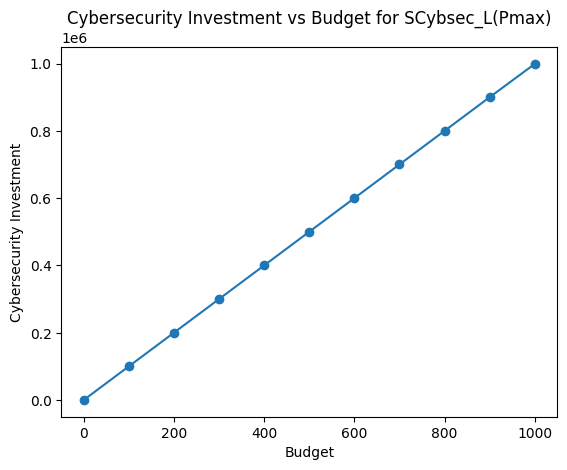

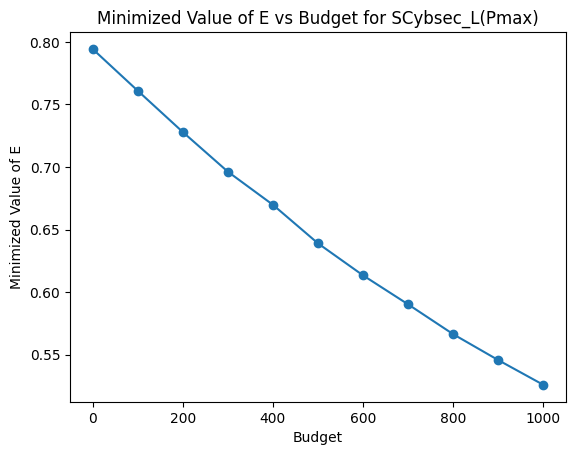

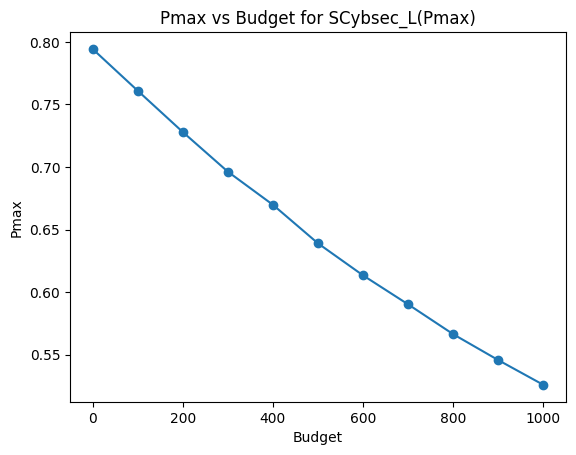

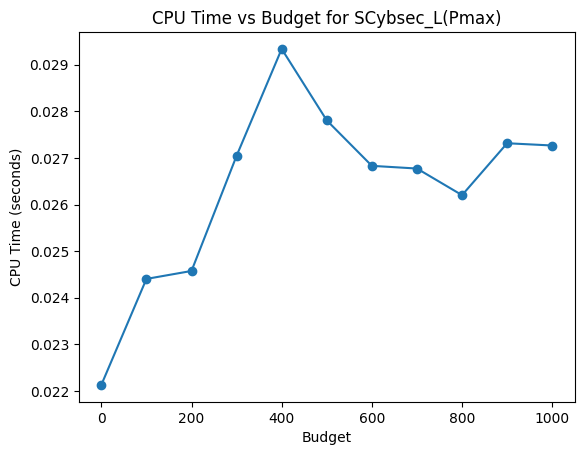

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 10.0, 10.0, 70.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 165.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 55.0, 235.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 35.0, 70.0, 285.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 400.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 120.0, 470.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 20.0, 135.0, 535.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 35.0, 155.0, 600.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 35.0, 170.0, 660.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 35.0, 185.0, 744.0]]
[[0.234955, 0.30820000000000003, 0.234185, 0.1583891666666667, 0.32634266666666667, 0.16368716666666666, 0.5219455000000001, 0.513958, 0.78184175, 0.79436675], [0.234955, 0.30820000000000003, 0.234185, 0.1583891666666667, 0.32634266666666667, 0.16368716666666666, 0.47417686150000005, 0.4598822310000001, 0.760997737125, 0.760342057125], [0.234955, 0.30820000000000003, 0.234185

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def minimize_Pmax(c, d, p, q, V, r, budget, H):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Minimize_Pmax", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node
    Pmax = pulp.LpVariable("Pmax", lowBound=0)


    # Define constraints
    # yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    # yes
    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))
                # else:
                #     prob += (pulp.lpSum(r[i][j][l] * v[i, j, l_prime] for l_prime in range(num_levels))== 0)
    #yes
    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))

    # Budget constraint
    # yes
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
    
    # New constraint for Pmax
    for i in range(num_nodes):
        prob += p[i] * W[i] + pulp.lpSum(q[h][i] * p[h] * W[h] for h in range(num_nodes)) <= Pmax

    # Define objective function
    prob += Pmax

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # Solve using CBC with 4 threads
    # solver = pulp.PULP_CBC_CMD(threads=4, msg=True)
    # prob.solve(solver)

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
           
    # print("W")
    # for i in range(num_nodes):
    #     print(f"W[{i}] = {W[i].varValue}")

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Cybersecurity investment per node
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].varValue for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    
    # breach probability by node
    breach_prob_per_node = [p[i] * W[i].varValue + sum(q[h][i] * p[h] * W[h].varValue for h in range(num_nodes)) for i in range(num_nodes)]

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    print("Objective function:", minimized_value/1000)
    print("Pmax: ", Pmax.varValue)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment,  minimized_value, Pmax.varValue, end_time - start_time, cybersecurity_investment_per_node, breach_prob_per_node


def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r

def get_graph_values(children):
    # n = max(max(c, default=-1) for c in children) + 1  # Find max node index
    n = len(children)
    # print(len(children))
    print(n)
    
    q = [[0] * n for _ in range(n)]  # Initialize an n x n matrix with zeros
    
    # Ensure all nodes (including those without children) are in the adjacency list
    full_children = {i: children[i] if i < len(children) else [] for i in range(n)}

    # Compute the number of children including itself for each node
    def count_children(node, memo={}):
        if node in memo:
            return memo[node]
        count = 1  # Include itself
        for child in full_children[node]:
            count += count_children(child, memo)
        memo[node] = count
        return count
    
    children_count = [count_children(i) - 1 for i in range(n)]  # Excluding itself
    children_count_with_self = [count_children(i) for i in range(n)]  # Including itself
    
    # Fill the q matrix
    for i in range(n):
        for j in full_children[i]:  # Only direct children of i
            if children_count[i] > 0:  # Avoid division by zero
                q[i][j] = children_count_with_self[j] / children_count[i]
    
    # Divide all elements of q by n
    q = [[q[i][j] / n for j in range(n)] for i in range(n)]
    
    return q

c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# q = 0.1
children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9],
            [],
            []]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]

q = get_graph_values(children)
print("q:")
print(q)

# Calculate r
r = calculate_r(V, e, c)
budgets = range(0, 1001, 100)
# budgets = [1000, 5000, 10000, 15000, 25000]

cybersecurity_investments = []
minimized_values = []
Pmax_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, minimized_value, Pmax, cpu_time, C_per_node, breach_per_node = minimize_Pmax(c, d, p, q, V, r, budget*1000, h_parents)
    cybersecurity_investments.append(investment)
    minimized_values.append(minimized_value)
    Pmax_values.append(Pmax)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    print()

# Plotting
plt.figure()
plt.plot(budgets, cybersecurity_investments, marker='o')
plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Pmax)')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Investment')
plt.show()

plt.figure()
plt.plot(budgets, minimized_values, marker='o')
plt.title('Minimized Value of E vs Budget for SCybsec_L(Pmax)')
plt.xlabel('Budget')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(budgets, Pmax_values, marker='o')
plt.title('Pmax vs Budget for SCybsec_L(Pmax)')
plt.xlabel('Budget')
plt.ylabel('Pmax')
plt.show()

plt.figure()
plt.plot(budgets, cpu_times, marker='o')
plt.title('CPU Time vs Budget for SCybsec_L(Pmax)')
plt.xlabel('Budget')
plt.ylabel('CPU Time (seconds)')
plt.show()

print(C_per_nodes)
print(breach_per_nodes)


# SCybsec_L(Lmax)

## Original

Budget = 0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ca88a97f861040209b04042e49b77721-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/ca88a97f861040209b04042e49b77721-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1796 COLUMNS
At line 12601 RHS
At line 14393 BOUNDS
At line 15194 ENDATA
Problem MODEL has 1791 rows, 1611 columns and 9203 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8.43308e+06 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 8.43308e+06 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds

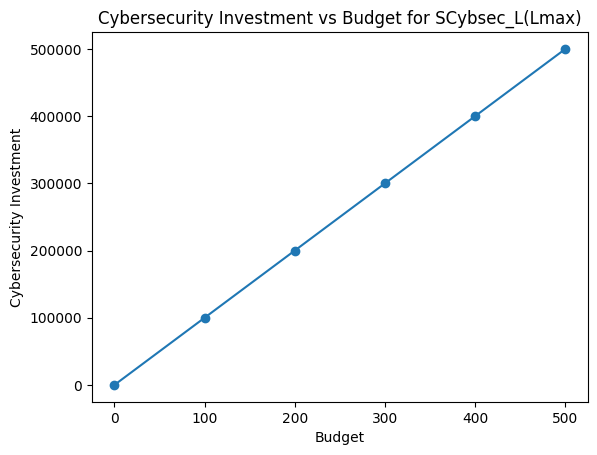

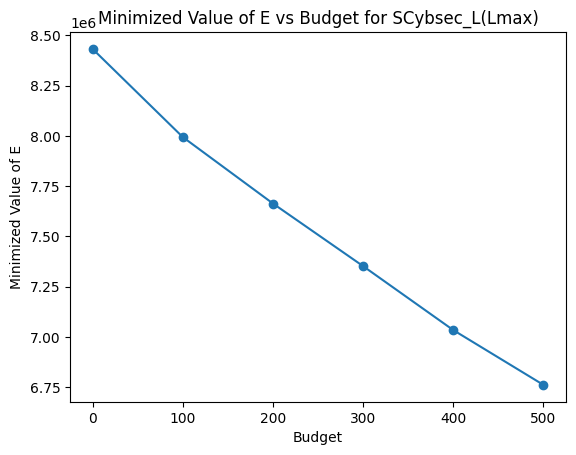

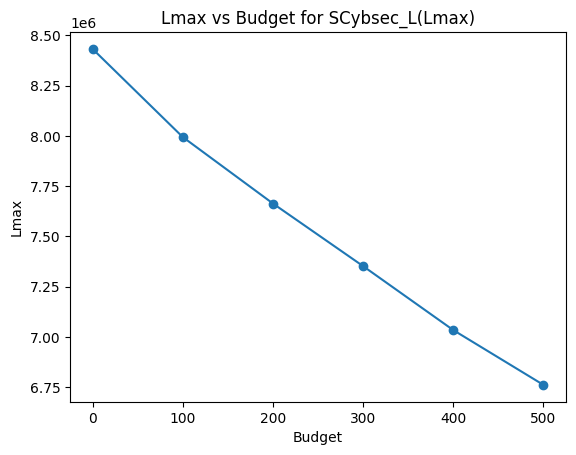

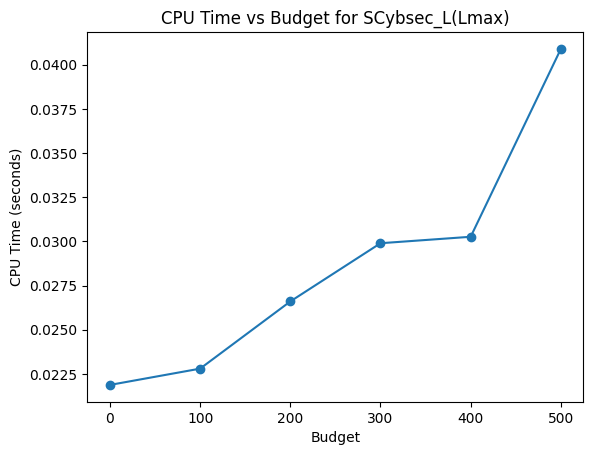

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 35.0, 0.0, 30.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 45.0, 20.0, 100.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 35.0, 45.0, 185.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 55.0, 55.0, 235.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 85.0, 70.0, 285.0]]
[[0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.5375435000000001, 0.529556, 0.8307835, 0.8433085], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.36308679600000004, 0.7991458115, 0.7994495014999999], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.3275658215, 0.76475455405, 0.7663677290500001], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.36308679600000004, 0.7300699565, 0.7351904315], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def minimize_Lmax(c, d, p, q, V, r, budget, H):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Minimize_Lmax", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node
    Lmax = pulp.LpVariable("Lmax", lowBound=0)


    # Define constraints
    # yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    # yes
    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))
                # else:
                #     prob += (pulp.lpSum(r[i][j][l] * v[i, j, l_prime] for l_prime in range(num_levels))== 0)
    #yes
    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))

    # Budget constraint
    # yes
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
    
    # New constraint for Pmax
    for i in range(num_nodes):
        prob += p[i] * W[i] + pulp.lpSum(q * p[h] * W[h] for h in H[i]) <= Lmax * (1 / d[i])

    # Define objective function
    prob += Lmax

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
           
    # print("W")
    # for i in range(num_nodes):
    #     print(f"W[{i}] = {W[i].varValue}")

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Cybersecurity investment per node
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].varValue for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    
    # breach probability by node
    breach_prob_per_node = [p[i] * W[i].varValue + sum(q * p[h] * W[h].varValue for h in H[i]) for i in range(num_nodes)]

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    print("Objective function:", minimized_value/1000)
    print("Lmax: ", Lmax.varValue)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment,  minimized_value, Lmax.varValue, end_time - start_time, cybersecurity_investment_per_node, breach_prob_per_node


def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
q = 0.1
children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9]]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]
# Calculate r
r = calculate_r(V, e, c)
budgets = range(0, 501, 100)

cybersecurity_investments = []
minimized_values = []
Lmax_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, minimized_value, Lmax, cpu_time, C_per_node, breach_per_node = minimize_Lmax(c, d, p, q, V, r, budget*1000, h_parents)
    cybersecurity_investments.append(investment)
    minimized_values.append(minimized_value)
    Lmax_values.append(Lmax)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    print()

# Plotting
plt.figure()
plt.plot(budgets, cybersecurity_investments, marker='o')
plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Lmax)')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Investment')
plt.show()

plt.figure()
plt.plot(budgets, minimized_values, marker='o')
plt.title('Minimized Value of E vs Budget for SCybsec_L(Lmax)')
plt.xlabel('Budget')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(budgets, Lmax_values, marker='o')
plt.title('Lmax vs Budget for SCybsec_L(Lmax)')
plt.xlabel('Budget')
plt.ylabel('Lmax')
plt.show()

plt.figure()
plt.plot(budgets, cpu_times, marker='o')
plt.title('CPU Time vs Budget for SCybsec_L(Lmax)')
plt.xlabel('Budget')
plt.ylabel('CPU Time (seconds)')
plt.show()

print(C_per_nodes)
print(breach_per_nodes)


## Network

# SCybsec_L(Qmin)

## Original

Budget = 0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e04d7ddc1143403d9a10fa3ff51d7137-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/e04d7ddc1143403d9a10fa3ff51d7137-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1796 COLUMNS
At line 12601 RHS
At line 14393 BOUNDS
At line 15194 ENDATA
Problem MODEL has 1791 rows, 1611 columns and 9203 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.156691 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -0.156692 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds

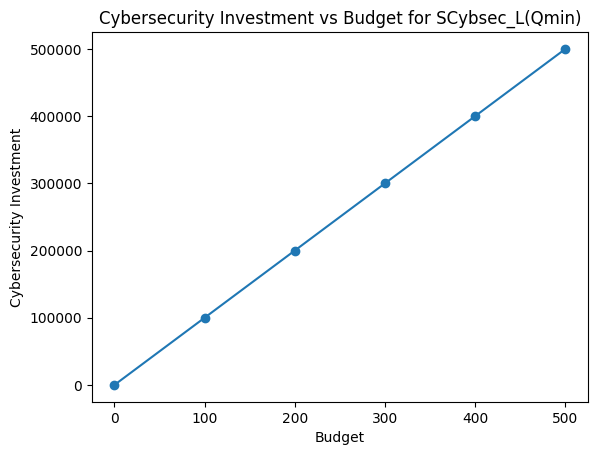

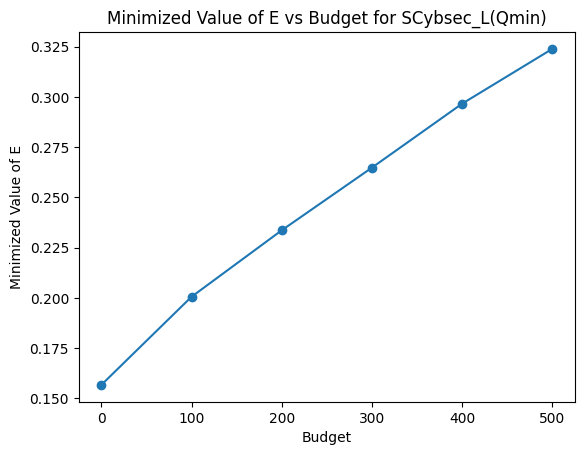

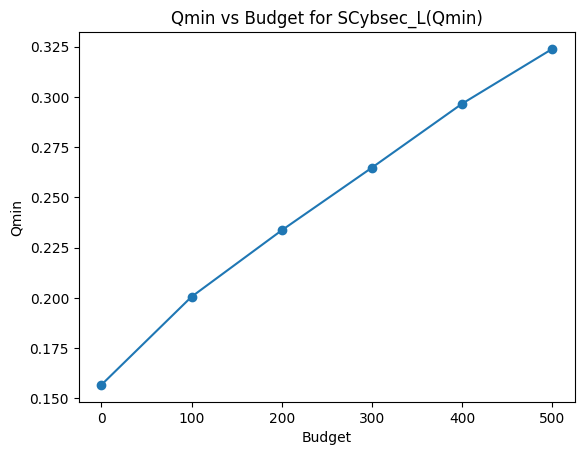

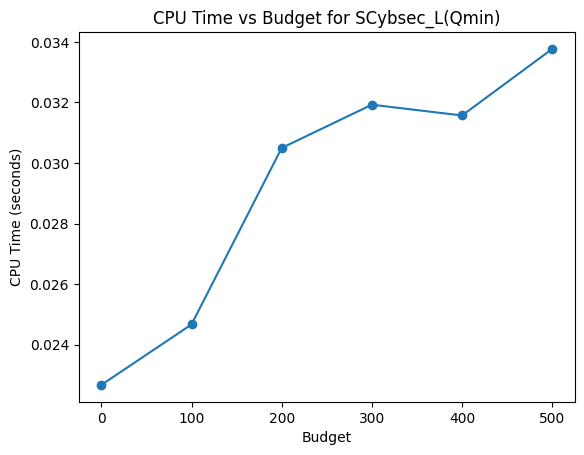

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 35.0, 0.0, 30.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 45.0, 20.0, 100.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 35.0, 45.0, 185.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 55.0, 55.0, 235.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 85.0, 70.0, 285.0]]
[[0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.5375435000000001, 0.529556, 0.8307835, 0.8433085], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.36308679600000004, 0.7991458115, 0.7994495014999999], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.3275658215, 0.76475455405, 0.7663677290500001], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.36308679600000004, 0.7351850615, 0.7351904315], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def maximize_Qmin(c, d, p, q, V, r, budget, H):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Maximize_Qmin", pulp.LpMaximize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node
    Qmin = pulp.LpVariable("Qmin", lowBound=0)


    # Define constraints
    # yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    # yes
    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))
                # else:
                #     prob += (pulp.lpSum(r[i][j][l] * v[i, j, l_prime] for l_prime in range(num_levels))== 0)
    #yes
    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))

    # Budget constraint
    # yes
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
    
    # New constraint for Pmax
    for i in range(num_nodes):
        prob += p[i] * W[i] + pulp.lpSum(q * p[h] * W[h] for h in H[i]) <= 1 - Qmin

    # Define objective function
    prob += Qmin

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
           
    # print("W")
    # for i in range(num_nodes):
    #     print(f"W[{i}] = {W[i].varValue}")

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Cybersecurity investment per node
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].varValue for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    
    # breach probability by node
    breach_prob_per_node = [p[i] * W[i].varValue + sum(q * p[h] * W[h].varValue for h in H[i]) for i in range(num_nodes)]

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    print("Objective function:", minimized_value/1000)
    print("Qmin: ", Qmin.varValue)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment,  minimized_value, Qmin.varValue, end_time - start_time, cybersecurity_investment_per_node, breach_prob_per_node


def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
q = 0.1
children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9]]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]
# Calculate r
r = calculate_r(V, e, c)
budgets = range(0, 501, 100)

cybersecurity_investments = []
minimized_values = []
Qmin_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, minimized_value, Qmin, cpu_time, C_per_node, breach_per_node = maximize_Qmin(c, d, p, q, V, r, budget*1000, h_parents)
    cybersecurity_investments.append(investment)
    minimized_values.append(minimized_value)
    Qmin_values.append(Qmin)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    print()

# Plotting
plt.figure()
plt.plot(budgets, cybersecurity_investments, marker='o')
plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Qmin)')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Investment')
plt.show()

plt.figure()
plt.plot(budgets, minimized_values, marker='o')
plt.title('Minimized Value of E vs Budget for SCybsec_L(Qmin)')
plt.xlabel('Budget')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(budgets, Qmin_values, marker='o')
plt.title('Qmin vs Budget for SCybsec_L(Qmin)')
plt.xlabel('Budget')
plt.ylabel('Qmin')
plt.show()

plt.figure()
plt.plot(budgets, cpu_times, marker='o')
plt.title('CPU Time vs Budget for SCybsec_L(Qmin)')
plt.xlabel('Budget')
plt.ylabel('CPU Time (seconds)')
plt.show()

print(C_per_nodes)
print(breach_per_nodes)


## Network

# SCybsec_L(Smin)

## Original

Budget = 0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3b415c8c5cc44ab4a647536c98e0dbbe-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/3b415c8c5cc44ab4a647536c98e0dbbe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1796 COLUMNS
At line 12601 RHS
At line 14393 BOUNDS
At line 15194 ENDATA
Problem MODEL has 1791 rows, 1611 columns and 9203 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.156691 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -0.156692 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds

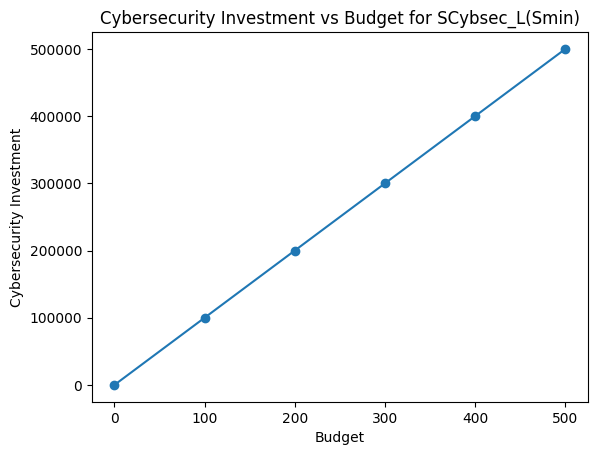

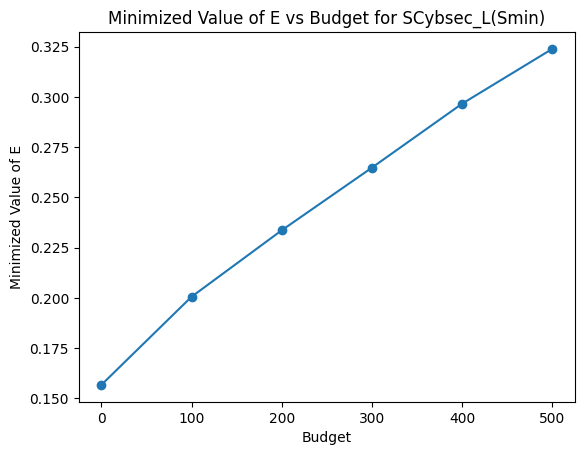

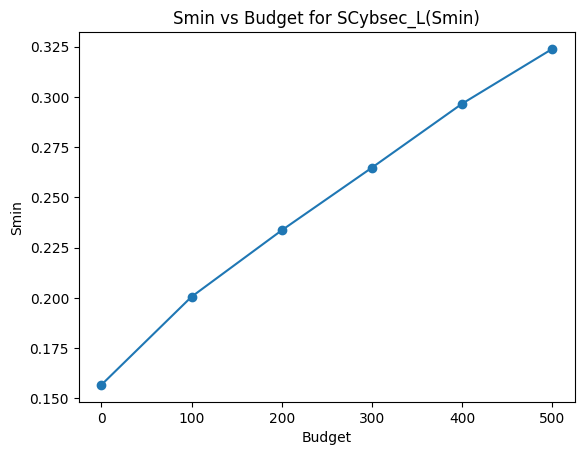

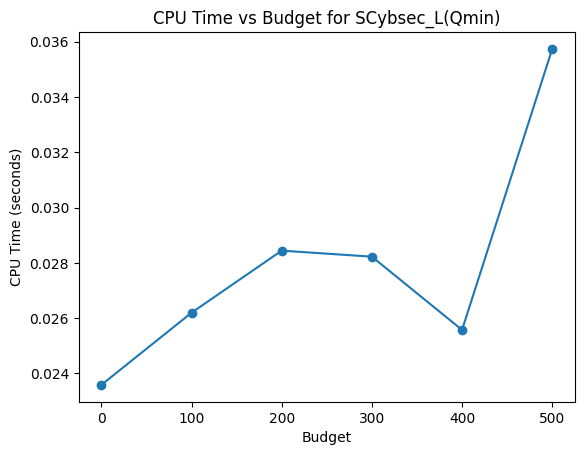

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 35.0, 0.0, 30.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 45.0, 20.0, 100.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 35.0, 45.0, 185.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 55.0, 55.0, 235.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 85.0, 70.0, 285.0]]
[[0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.5375435000000001, 0.529556, 0.8307835, 0.8433085], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.36308679600000004, 0.7991458115, 0.7994495014999999], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.3275658215, 0.76475455405, 0.7663677290500001], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0.1862885, 0.387635819, 0.36308679600000004, 0.7351850615, 0.7351904315], [0.234955, 0.30820000000000003, 0.234185, 0.1809905, 0.34278000000000003, 0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def maximize_Smin(c, d, p, q, V, r, budget, H):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Maximize_Smin", pulp.LpMaximize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node
    Smin = pulp.LpVariable("Smin", lowBound=0)


    # Define constraints
    # yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    # yes
    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    #yes
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))
                # else:
                #     prob += (pulp.lpSum(r[i][j][l] * v[i, j, l_prime] for l_prime in range(num_levels))== 0)
    #yes
    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))

    # Budget constraint
    # yes
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
    
    # New constraint for Pmax
    for i in range(num_nodes):
        prob += p[i] * W[i] + pulp.lpSum(q * p[h] * W[h] for h in H[i]) <= 1 - Smin * (1 / d[i])

    # Define objective function
    prob += Smin

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
           
    # print("W")
    # for i in range(num_nodes):
    #     print(f"W[{i}] = {W[i].varValue}")

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Cybersecurity investment per node
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].varValue for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    
    # breach probability by node
    breach_prob_per_node = [p[i] * W[i].varValue + sum(q * p[h] * W[h].varValue for h in H[i]) for i in range(num_nodes)]

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    print("Objective function:", minimized_value/1000)
    print("Smin: ", Smin.varValue)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment,  minimized_value, Smin.varValue, end_time - start_time, cybersecurity_investment_per_node, breach_prob_per_node


def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
q = 0.1
children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9],
            [],
            []]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]
# Calculate r
r = calculate_r(V, e, c)
budgets = range(0, 501, 100)

cybersecurity_investments = []
minimized_values = []
Smin_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, minimized_value, Smin, cpu_time, C_per_node, breach_per_node = maximize_Qmin(c, d, p, q, V, r, budget*1000, h_parents)
    cybersecurity_investments.append(investment)
    minimized_values.append(minimized_value)
    Smin_values.append(Smin)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    print()

# Plotting
plt.figure()
plt.plot(budgets, cybersecurity_investments, marker='o')
plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Smin)')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Investment')
plt.show()

plt.figure()
plt.plot(budgets, minimized_values, marker='o')
plt.title('Minimized Value of E vs Budget for SCybsec_L(Smin)')
plt.xlabel('Budget')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(budgets, Smin_values, marker='o')
plt.title('Smin vs Budget for SCybsec_L(Smin)')
plt.xlabel('Budget')
plt.ylabel('Smin')
plt.show()

plt.figure()
plt.plot(budgets, cpu_times, marker='o')
plt.title('CPU Time vs Budget for SCybsec_L(Qmin)')
plt.xlabel('Budget')
plt.ylabel('CPU Time (seconds)')
plt.show()

print(C_per_nodes)
print(breach_per_nodes)


## Network

In [5]:
import numpy as np
from collections import deque

def binary_reachability(adj_list):
    """Returns a 2D array where P[i][j] = 1 if there is a path from i to j, else 0."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))
    
    def dfs(start, node):
        if P[start][node] == 1:
            return
        P[start][node] = 1
        for child in adj_list[node]:
            dfs(start, child)
    
    for i in range(num_nodes):
        dfs(i, i)  # Start DFS from each node
    
    return P

def path_length_inverse(adj_list):
    """Returns a 2D array where P[i][j] = 1/d(i, j), with d(i, j) as the shortest path length."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        queue = deque([(i, 0)])  # (current_node, distance)
        visited = set()
        
        while queue:
            node, dist = queue.popleft()
            if node in visited:
                continue
            visited.add(node)
            
            if node != i and dist > 0:
                P[i][node] = 1 / dist  # Assign inverse path length
            
            for child in adj_list[node]:
                if child not in visited:
                    queue.append((child, dist + 1))
    
    return P

def path_count_normalization(adj_list):
    """Returns a 2D array where P[i][j] is the fraction of paths from i to j."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))
    
    def count_paths(i, j, memo):
        if i == j:
            return 1
        if (i, j) in memo:
            return memo[(i, j)]
        paths = sum(count_paths(child, j, memo) for child in adj_list[i])
        memo[(i, j)] = paths
        return paths
    
    for i in range(num_nodes):
        memo = {}
        total_paths = sum(count_paths(i, k, memo) for k in range(num_nodes) if k != i)
        if total_paths > 0:
            for j in range(num_nodes):
                if j != i:
                    P[i][j] = count_paths(i, j, memo) / total_paths
    
    return P

def decay_factor_over_distance(adj_list, lambda_=0.5):
    """Returns a 2D array where P[i][j] = e^(-lambda * d(i, j))."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        queue = deque([(i, 0)])  # (current_node, distance)
        visited = set()
        
        while queue:
            node, dist = queue.popleft()
            if node in visited:
                continue
            visited.add(node)
            
            if node != i:
                P[i][node] = np.exp(-lambda_ * dist)
            
            for child in adj_list[node]:
                if child not in visited:
                    queue.append((child, dist + 1))
    
    return P

def influence_flow(adj_list):
    """Returns a 2D array where influence is distributed based on outgoing edges."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        queue = deque([i])
        visited = set()
        influence = {i: 1}  # Start with full influence at the source
        
        while queue:
            node = queue.popleft()
            if node in visited:
                continue
            visited.add(node)
            
            children = adj_list[node]
            if children:
                spread = influence.get(node, 0) / len(children)  # Avoid KeyError
                for child in children:
                    if child not in influence:
                        influence[child] = 0  # Ensure all nodes are initialized
                    P[i][child] += spread
                    influence[child] += spread
                    queue.append(child)
    
    return P


def weighted_path_contribution(adj_list):
    """Returns a 2D array where P[i][j] is the sum of 1/d(i,j) over all paths from i to j."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))
    
    def dfs(i, j, depth):
        if i == j:
            return 1 / max(1, depth)  # Avoid division by zero
        return sum(dfs(child, j, depth + 1) for child in adj_list[i])

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                P[i][j] = dfs(i, j, 0)
    
    return P


def random_walk_influence(adj_list, lambda_=0.85):
    """Returns a 2D array where P[i][j] represents influence spread through a random walk."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))
    
    def walk(i, j, prob):
        if i == j:
            return prob
        if not adj_list[i]:  # No outgoing edges
            return 0
        spread = prob * lambda_ / len(adj_list[i])
        return sum(walk(child, j, spread) for child in adj_list[i])

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                P[i][j] = walk(i, j, 1)
    
    return P


def network_flow_capacity(adj_list):
    """Returns a 2D array where P[i][j] represents total number of independent paths from i to j."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def count_paths(i, j):
        if i == j:
            return 1
        return sum(count_paths(child, j) for child in adj_list[i])

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                P[i][j] = count_paths(i, j)
    
    return P


def heat_diffusion_model(adj_list):
    """Returns a 2D array where P[i][j] follows a heat diffusion model: e^(-d(i,j))."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        queue = deque([(i, 0)])  # (current_node, distance)
        visited = set()
        
        while queue:
            node, dist = queue.popleft()
            if node in visited:
                continue
            visited.add(node)
            if node != i:
                P[i][node] = np.exp(-dist)
            
            for child in adj_list[node]:
                queue.append((child, dist + 1))

    return P


def eigenvector_centrality_influence(adj_list):
    """Returns a 2D array where P[i][j] is based on eigenvector centrality of nodes."""
    num_nodes = len(adj_list)
    A = np.zeros((num_nodes, num_nodes))

    for i, children in enumerate(adj_list):
        for child in children:
            A[i][child] = 1

    # Compute eigenvector centrality
    eigenvalues, eigenvectors = np.linalg.eig(A)
    centrality = np.abs(eigenvectors[:, np.argmax(eigenvalues.real)])  # Dominant eigenvector

    P = np.outer(centrality, centrality)  # Influence spreads from central nodes
    return P



# Example adjacency list (Directed Acyclic Graph)
children = [[3], [3, 4, 5], [5], [6], [6, 7], [7], [8, 9], [8, 9], [], []]

# Compute propagation coefficients using each method
P_binary = binary_reachability(children)
P_inverse = path_length_inverse(children)
P_path_count = path_count_normalization(children)
P_decay = decay_factor_over_distance(children, lambda_=0.5)
P_influence = influence_flow(children)
P_weighted = weighted_path_contribution(children)
P_random_walk = random_walk_influence(children)
P_network_flow = network_flow_capacity(children)
P_heat_diffusion = heat_diffusion_model(children)
P_eigenvector = eigenvector_centrality_influence(children)

# Print results
print("Binary Reachability:\n", P_binary)
print("Path Length Inverse:\n", P_inverse)
print("Path Count Normalization:\n", P_path_count)
print("Decay Factor Over Distance:\n", P_decay)
print("Influence Flow:\n", P_influence)
print("Weighted Path Contribution:\n", P_weighted)
print("Random Walk Influence:\n", P_random_walk)
print("Network Flow Capacity:\n", P_network_flow)
print("Heat Diffusion Model:\n", P_heat_diffusion)
print("Eigenvector Centrality Influence:\n", P_eigenvector)


Binary Reachability:
 [[1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Path Length Inverse:
 [[0.         0.         0.         1.         0.         0.
  0.5        0.         0.33333333 0.33333333]
 [0.         0.         0.         1.         1.         1.
  0.5        0.5        0.33333333 0.33333333]
 [0.         0.         0.         0.         0.         1.
  0.         0.5        0.33333333 0.33333333]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.5        0.5       ]
 [0.         0.         0.         0.         0.         0.
  1.         1.         0.5        0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.5   

Binary Reachability:
 [[1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Normalized Path Count:
 [[0.2        0.         0.         0.2        0.         0.
  0.2        0.         0.2        0.2       ]
 [0.         0.0625     0.         0.0625     0.0625     0.0625
  0.125      0.125      0.25       0.25      ]
 [0.         0.         0.2        0.         0.         0.2
  0.         0.2        0.2        0.2       ]
 [0.         0.         0.         0.25       0.         0.
  0.25       0.         0.25       0.25      ]
 [0.         0.         0.         0.         0.14285714 0.
  0.14285714 0.14285714 0.28571429 0.28571429]
 [0.         0.         0.         0.         0.         0.25
  0.         0.25    